In [1]:
# This is a playground file where I want to implement search itself

import pandas as pd
import numpy as np

In [2]:
        
class SearchEngine:
    
    def __init__(self, google_matrix: np.ndarray , webpages_dictionary: dict, webpages_names: dict) -> None:
        """
        Function to initiate search engine.
        Warns if matrix is not row-stohastic
        Creates a ranking based on provided google matrix.
        By default does not enhance matrix by adding alpha-matrix to it
        
        Args:
            google_matrix (np.ndarray): google matrix
            webpages_dictionary (dict): webpage_short_name : tags
            webpages_names (dict): webpage_short_name: document_name
        """
        
        # set default variables
        self._webpages_dictionary = webpages_dictionary
        self._webpages_names = webpages_names
        self._num_of_sites = len(self._webpages_dictionary)
        self._google = google_matrix
        self._ranking = []
        self._terms = self._get_terms()
        self._disable_warnings = False
        self._term_document_matrix = self._create_term_document_matrix()
        if self._check_stohastic_matrix():
            print("Recieved a stohastic matrix")
        else:
            print("Recieved a non-stohastic matrix")
       
        # Prepare for the search
        self.update_ranking()
        
        # print stuff
            
    def _matprint(self, mat, fmt="g"):
        col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
        for x in mat:
            for i, y in enumerate(x):
                print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
            print("")
    
    def _check_stohastic_matrix(self):
        for i in self._google:
            tmp = i.sum()
            if tmp != 1:
                return False
        return True
        
    def _interpret_ranking_vector(self, vector: np.ndarray) -> None:
        vector = np.array(vector)
        sor = sorted(vector, reverse=True)
        result = []
        for i in sor:
            index = np.where(vector == i)[0]
            # if only one element:
            if index.size == 1:
                result.append(chr(index[0]+65))
            else:
                for j in index:
                    tmp = chr(j+65)
                    if tmp not in result:
                        result.append(tmp)
        self._ranking = result

    def _create_term_document_matrix(self):
        outer_matrix = []
        for i in self._terms:
            tmp = []
            for j in self._webpages_dictionary:
                if i in [k.lower() for k in self._webpages_dictionary[j]]:
                   tmp.append(1)
                else:
                    tmp.append(0)
            outer_matrix.append(tmp)
        return np.array(outer_matrix) 
            
    def _get_terms(self):
        all_terms = []
        for i in self._webpages_dictionary.values():
            for j in i:
                all_terms.append(j.lower())
        return list(set(all_terms))

    def get_websites_ranking(self, just_print=True) -> list:
        """
        Function to get websites ranking.
        DOES NOT update ranking, just prints it :)
        Args:
            just_print (bool, optional): if set to false, will return ranking instead of printing it. Defaults to True.

        Returns:
            Webpage ranking (if specified)
        """
        result = ""
        for i, j in enumerate(np.array(self._ranking)):
            try:
                result += f"{i+1}. {j}: {self._webpages_names[j]}"
                result += '\n'
            except KeyError:
                print("Wrong vector")
                return
        if just_print:
            print(result)
            return
        return result
        
    def get_google_matrix(self):
        """Returns current google matrix

        Returns:
            np.ndarray (current google matrix)
        """
        return self._google
    
    def strongly_connect_matrix(self, alpha=0.85)->None:
        """
        Updates current matrix to a*G + (1-a)*E.
        If you need current matrix, recommend saving it somewhere
        (with get_google_matrix) before using this function.
            
        Args:
            alpha (float, optional): alpha. Defaults to 0.85.
        """
        if alpha >= 1 or alpha <= 0:
            print("Alpha has to be between 0 and 1 exclusively")
            return
        ones = (1-alpha)*(1/self._num_of_sites)*np.full((self._num_of_sites, self._num_of_sites), 1)
        self._google = alpha * self._google + ones

    # returns number of iterations
    def update_ranking(self, epsilon = np.finfo(float).eps, show_graph=False)->int:
        """
        Using power iteration to update webpages ranking.
        If matrix is row-stohastic, then number of iterations is not limited. Otherwise,
        limited by 1000.
        Power iteration occurs until difference between last and current ranking vector (delta)
        becomes less than epsilon.
        
        By default epsilon is equal to floating number machine epsilon of numpy (about 10^-16)
        Also shows delta with number of iterations (enable show_graps=True to work)

        Args:
            epsilon (_type_, optional): epsilon. Defaults to np.finfo(float).eps.
            show_graph (bool, optional): Dispaly graph. Defaults to False.

        Returns:
            int: number of iterations
        """
        limit = False
        if not self._check_stohastic_matrix():
            if not self._disable_warnings:
                print("Warning, non stohastic matrix. Limiting number of iterations to 1000")
            limit = True
        pi = np.array([1/12 for i in range(self._num_of_sites)])
        count = 0
        # numpy machine epsilon
        diff = 1

        # error vector to make graph later (maybe)
        errors = []
        while(diff > epsilon):
            tmp = np.matmul(np.transpose(pi), self._google)
            tmp = np.transpose(tmp)
            diff = np.linalg.norm(tmp-pi)
            errors.append(diff)
            pi = tmp
            count += 1
            
            # if limited
            if limit and count >= 1000:
                break
            
        if show_graph:
            df = pd.DataFrame(errors)
            ax = df.plot(title="Error with number of iterations")
            ax.set_xlabel("Count")
            ax.set_ylabel("Error")

        self._interpret_ranking_vector(np.array(pi))
        return count

    def print_google_matrix(self):
        """
        Prints out current google matrix
        """
        self._matprint(self._google)

    def interestign_stuff(self, start=1, stop=99, step=1, multiplier=100):
        """
            Plots a graph of the number of iterations before convergences
            for power iteration with different alphas.
            Underhood uses standard python range functions and is limited to its erros.
            Actual alpha taht is substituted = current_alpha/multiplier
            Be careful with parameters.
        """
        dw = self._disable_warnings
        self._disable_warnings = True
        stash_matrix = self._google
        counts = []
        for alpha in range(start, stop, step):
            self._google = stash_matrix
            self.strongly_connect_matrix(alpha/multiplier)
            counts.append(self.update_ranking())
        self._google = stash_matrix
        self._disable_warnings = dw
        self.update_ranking()
        df = pd.DataFrame(counts)
        ax = df.plot(title="Number of iterations with different alpha's")
        ax.set_xlabel("Alpha * 100")
        ax.set_ylabel("Number of iterations")
        
    def print_documentation(self):
        print("""
            Hello, Doctor Varn.
            This is our little playground for you.
            Initial setup is made with our google matrix and our given tags and websites.
            You could use different parameters, if you provide SearchEngine class with
            different parameters.
            
            Functions that start with "_" are inner to a class, and are not meant for use by outsiders.
            Feel free to play with them, but no documentation for them is provided.
            
            Other functions are provided with documentation, you should be able to get it when hovering over them.
            Therefore, I will shortly providee you with information about them:
            
            1) get_websites_ranking() - Returns current ranking of websites (does not update it)
                by default, just prints them. If just_print = False - returns them as a str
            2) get_google_matrix() - Returns currently stored google matrix (as numpy.ndarray)
              
            3) strongly_connect_matrix() - Updates currently stored matrix, to make it strongly connected
            alpha can be specified, and is defaulted to 0.85
            
            4) update_ranking() - Uses power iteration to update ranking of websites (does not output them, just innerly updates)
            Epsilon is difference between last and current vectors. Defaults to numpy machine epsilon (10^-16).
            Set show_graph = True, to witness more statistics.
            
            5) print_google_matrix() - print current google matrix
              
            6) interestign_stuff() - Function that outputs number of iteration that were needed to converge depending on alpha.
              
            7) search() - Actual search implementation  
              """)
        
    def print_search_documentation(self):
        print(f"""
            This part is tricky.
            Provides you with a ranking of websites based on the query.
            Please use spaces to separate queries. e.g. follow format:
                tag tag tag
            
            
            Search has three modes that it can operate, it is also case insensitive
            
            1) 'And' mode - default search mode. Will return documents that have ALL tags
            specified in the query. 
            Also supports excluding tags. If '!' is specified before tag, then it will search
            for websites with all other tags and NOT specified ta
            
            Ex.
            'Anchovy Ruper' - looks for both 'anchovy' and 'ruper'
            
            'Anchovy !Ruper' - looks for 'anchovy' and NOT 'ruper'
            
            'Anchovy !Ruper !Pike` - looks for 'anchovy' and NOT 'Pike' and NOT 'Ruper'
            
            2) 'Or mode' - does not support excluding. To activate mode insert 'or' anywhere in the query
            Returns websites that have at least one of the tags. Number of relative tags - is not reflected in the result
            (e.g. if one websites has two tags, and the other has one - their ranking depends only on google ranking, not number
            of tags.)
            
            Ex.
            'Anchovy or Ruper' - looks for 'anchovy' or 'ruper' or both
            'or Anchovy Ruper' - same as above
            
            3) 'Xor mode' - does not support excluding. To activate mode insert 'xor' anywhere in the query
            Returns websites that have ONLY ONE of the tags.
            
            Ex.
            'Anchovy xor Ruper' - looks for websites that have only 'anchovy' or only 'ruper' 
            'xor Anchovy Ruper' - same as above
        
              """)

    
    def search(self, query=""):
        """Implements search

        Supports several types of search. By default, 
        every search is limited to "and" type of search.
        "and" search also supports "not". If "!" is put before word, then
        it is specifically excluded from the result. Supported ONLY by "and"
        
        "Or" search - inclusive or search
        "Xor" search - exclusive or search.
        Both searches change interpretation of queries, and search method,
        they are not ad addition to "and" search.
        To use there mods, put "or" or "xor" into query.
        
        Search priority:
        1) Or
        2) Xor
        3) And
        
        Args:
            query (str, optional): If you do not want to enter query from keyboard. Defaults to "".
        """
        # if query is not provided, then ask for it
        if not query:
            self._print_search_documentation()
            query = input("Please enter a search query: ")    
        
        query = list(set([i.lower() for i in query.split(" ")]))
        search_type = "and"
        search_len = len(query) - 1
        if "or" in query:
            search_type = "or"
        elif "xor" in query:
            search_type = "xor"
        else:
            search_len += 1
        
        tmp = []
        num_of_negative = 0
        
        for i in self._terms:
            if i in query:
                tmp.append(1)
            elif "!" + i in query:
                num_of_negative += 1
                tmp.append(-1)
            else:
                tmp.append(0)
        results = np.matmul(np.array(tmp), self._term_document_matrix)
        
        if search_type == "and":
            results = [1 if i == search_len - num_of_negative else 0 for i in results]
        if search_type == "xor":
            results = [1 if i == 1 else 0 for i in results]
        if search_type == "or":
            results = [1 if i != 0 else 0 for i in results]    
        
        search_result = []
        for i in self._ranking:
            if results[ord(i)-65]:
                search_result.append(i)
        
        for i in search_result:
            print(f"{self._webpages_names[i]}")
            
            
        
        
            
        
        





    

Recieved a stohastic matrix
Warning, non stohastic matrix. Limiting number of iterations to 1000
1. J: Fish Eye Cafe
2. G: Friendly Fish
3. C: By the Sea
4. B: Finny’s Fried Fish
5. H: Frank’s Aquariums
6. F: It’s Better Wetter
7. I: Fishmonger’s Bane
8. L: Fishtastic
9. D: Scales and Tails
10. A: Tim’s Wet Pets
11. E: Fillets ’R Us
12. K: Happy Fins

Warning, non stohastic matrix. Limiting number of iterations to 1000


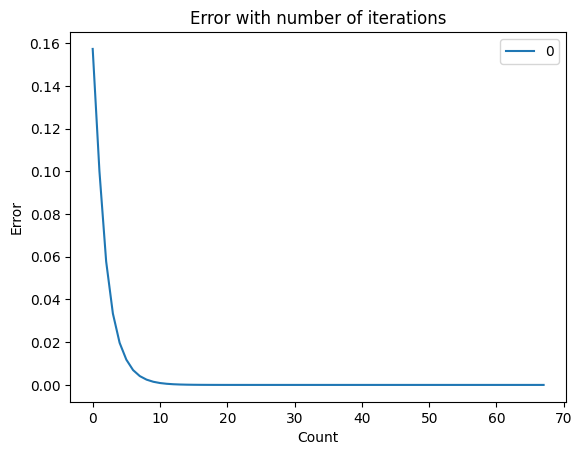

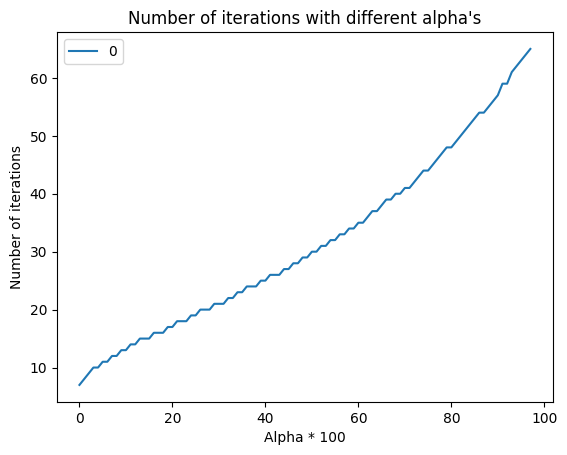

In [3]:

# actual playground
const_number_pages=12
webpage_dict = {'A':['Anchovy','Grouper', 'Mackerel', 'Pike', 'Salmon', 'Betta', 'Walleye'],
               'B': ['Grouper', 'Pike', 'Wahoo', 'Tuna', 'Shad', 'Cod', 'Carp', 'Opah', 'Herring'],
               'C':['Anchovy', 'Wahoo', 'Tuna', 'Opah', 'Mudskipper'],
               'D':['Mackerel', 'Pike', 'Wahoo', 'Salmon', 'Mudskipper'],
               'E':['Anchovy', 'Grouper', 'Shad', 'Mudskipper', 'Herring', 'Walleye'],
               'F':['Grouper', 'Cod', 'Betta', 'Carp', 'Perch', 'Mudskipper'],
               'G':['Mackerel', 'Tuna', 'Shad', 'Cod', 'Opah', 'Walleye'],
               'H':['Anchovy', 'Mackerel', 'Pike', 'Salmon', 'Perch', 'Herring'],
               'I':['Pike', 'Tuna', 'Cod', 'Salmon', 'Carp', 'Walleye'],
               'J':['Grouper', 'Mackerel', 'Tuna', 'Perch', 'Walleye'],
               'K':['Mackerel', 'Wahoo', 'Shad', 'Betta', 'Carp', 'Opah', 'Herring'],
               'L':['Grouper', 'Wahoo', 'Betta', 'Perch', 'Mudskipper', 'Herring']}

out_edge_network = {'A':['C','E'],
               'B':['A','C'],
               'C':[],
               'D':['B'],
               'E':['C','F','G','I'],
               'F':['C', 'B','D','H'],
               'G':['F','I'],
               'H':['D','G','J'],
               'I':['G','J','K'],
               'J':['G','H','L'],
               'K':['J'],
               'L':['J']}



webpage_names = {
    "A": "Tim’s Wet Pets",
    "B": "Finny’s Fried Fish",
    "C": "By the Sea",
    "D": "Scales and Tails", 
    "E": "Fillets ’R Us", 
    "F": "It’s Better Wetter" ,
    "G": "Friendly Fish",  
    "H": "Frank’s Aquariums", 
    "I": "Fishmonger’s Bane", 
    "J": "Fish Eye Cafe", 
    "K": "Happy Fins", 
    "L": "Fishtastic" 
}

# code to create our google matrix
mat = np.zeros(shape=(12,12))
for x in out_edge_network.keys():
    if len(out_edge_network[x]) == 0: 
        for y in range(0,len(mat[ord(x.lower()) - 97])):
            mat[ord(x.lower()) - 97][y] = 1/const_number_pages
    for y in out_edge_network[x]:
        mat[ord(x.lower()) - 97][ord(y.lower()) - 97] = 1/len(out_edge_network[x])


google = SearchEngine(mat, webpage_dict, webpage_names)
# google.print_documentation()
# google.print_search_documentation()

# Use examples

google.strongly_connect_matrix()
google.update_ranking(show_graph=True)
google.get_websites_ranking()
google.interestign_stuff()



In [4]:
google.search("Carp")

Finny’s Fried Fish
It’s Better Wetter
Fishmonger’s Bane
Happy Fins


In [5]:
google.search("Perch Mudskipper")

It’s Better Wetter
Fishtastic


In [6]:
google.search("Anchovy or Walleye")

Fish Eye Cafe
Friendly Fish
By the Sea
Frank’s Aquariums
Fishmonger’s Bane
Tim’s Wet Pets
Fillets ’R Us


In [86]:
google.search("Wahoo !Opah")

Fishtastic
Scales and Tails
